## Data

In [1]:
import pandas as pd

from matplotlib import pyplot as plt
import pylab as plot
import logging


pd.options.display.max_columns = 100
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
log = logging.getLogger()

In [2]:
import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv("../data/train.csv")
args.raw_test = pd.read_csv("../data/test.csv")
args.train_border_index = 891
args.val_border_index = 265
args.splits = 5
args.seed = 101
args.n_jobs = -1

In [3]:
print(args.raw_train.shape)
args.raw_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(args.raw_test.shape)
args.raw_test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Unknown data

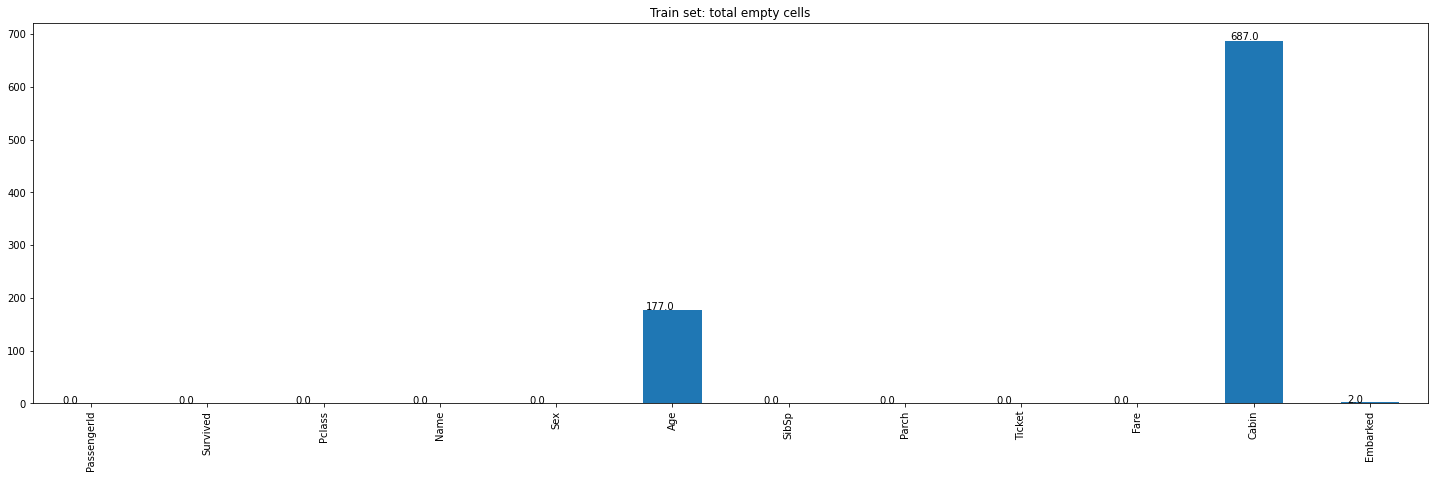

In [5]:
ax = args.raw_train.isna().sum().plot(kind='bar', figsize=(25, 7), stacked=True, title='Train set: total empty cells')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

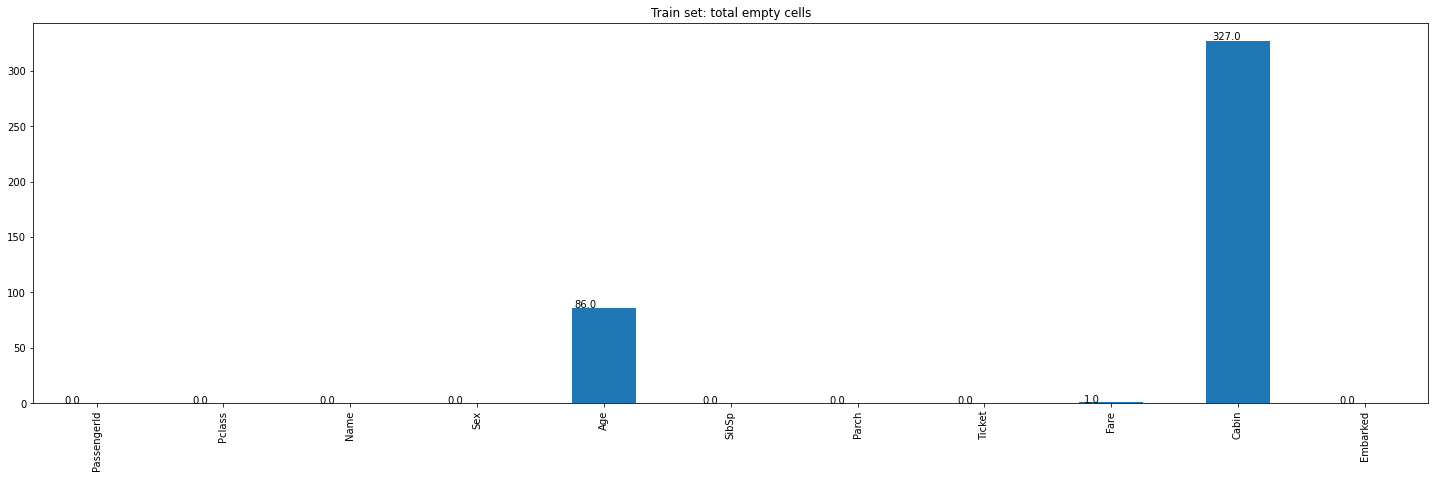

In [6]:
ax = args.raw_test.isna().sum().plot(kind='bar', figsize=(25, 7), stacked=True, title='Train set: total empty cells')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## Feature engineering

In [7]:
X = args.raw_train.copy().drop('Survived', axis=1)
y = args.raw_train.copy()['Survived']
X_test = args.raw_test.copy()

In [8]:
# median age

import numpy as np
from sklearn.pipeline import make_union, Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from functools import reduce
import re

class NameToTitleTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        names = X.to_numpy().reshape(len(X),)
    
        title_dictionary = {
            "Capt": "Officer",
            "Col": "Officer",
            "Major": "Officer",
            "Jonkheer": "Royalty",
            "Don": "Royalty",
            "Sir": "Royalty",
            "Dr": "Officer",
            "Rev": "Officer",
            "the Countess": "Royalty",
            "Mme": "Mrs",
            "Mlle": "Miss",
            "Ms": "Mrs",
            "Mr": "Mr",
            "Mrs": "Mrs",
            "Miss": "Miss",
            "Master": "Master",
            "Lady": "Royalty"
        }
        titles = [fullname.split(',')[1].split('.')[0].strip() for fullname in names]
        short_titles = [title_dictionary.get(title, "Royalty") for title in titles]
        return np.array(short_titles).reshape(len(short_titles), 1)

class SibspParchToFamilySizeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def _categorize_family_size(family_size_row):
            s_size = 0
            m_size = 4
            family_size = reduce(lambda x, y:x+y, family_size_row)
            if family_size == s_size:
                return 's'
            elif family_size <= m_size:
                return 'm'
            else:
                return 'l'
        family_size_categories = list(map(_categorize_family_size, np.asarray(X.to_numpy())))
        return np.array(family_size_categories).reshape(len(family_size_categories), 1)

class TicketTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def _clean_ticket(ticket):
            # replace all special chars
            ticket = re.sub('[^a-zA-Z0-9]', '', ticket)
            if ticket[0].isdigit():
                return 'digit'
            return ticket[0]
        ticket_categories = list(map(_clean_ticket, np.asarray(X.to_numpy().reshape(len(X),))))
        return np.array(ticket_categories).reshape(len(ticket_categories), 1)
    


pclass_pipeline = OneHotEncoder(categories='auto')
name_pipeline = make_pipeline(NameToTitleTransformer(), OneHotEncoder(categories='auto'))
sex_pipeline = OrdinalEncoder(dtype='int')
age_fare_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
sibsp_parch_pipeline = make_pipeline(SibspParchToFamilySizeTransformer(), OneHotEncoder(categories='auto'))
ticket_pipeline = make_pipeline(TicketTransformer(), OneHotEncoder(categories='auto'))
embarked_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(categories='auto'))

feature_engineering_col_transformer = ColumnTransformer(
    [('pclass_transformer', pclass_pipeline, ['Pclass']),
     ('name_transformer', name_pipeline, ['Name']),
     ('sex_transformer', sex_pipeline, ['Sex']),
     ('age_fare_transformer', age_fare_pipeline, ['Age', 'Fare']),
     ('sibsp_parch_transformer', sibsp_parch_pipeline, ['SibSp', 'Parch']),
     ('ticket_transformer', ticket_pipeline, ['Ticket']),
     ('embarked_transformer', embarked_pipeline, ['Embarked'])], 
    remainder='drop'
)

print("X's transformed shape:", feature_engineering_col_transformer.fit_transform(X).shape)

X's transformed shape: (891, 26)


## Pipeline baseline

In [9]:
def csv_predictions(predictions, filename):
    submission = pd.DataFrame({'PassengerId': args.raw_test['PassengerId'],'Survived': predictions})

    submission.to_csv(filename, index=False)
    print('Saved file: ' + filename)

In [10]:
# median age
from sklearn.ensemble import ExtraTreesClassifier

pipeline_clf = ExtraTreesClassifier(random_state=args.seed, n_jobs=-1, 
                                    **{'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10})

titanic_pipeline_baseline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('clf', pipeline_clf)
    ]
)

titanic_pipeline_baseline.fit(X, y)

def get_feature_names(pipeline):
    feature_names = []
    for transformer in pipeline.named_steps['feature-engineering'].transformers_:
        if 'transformer' not in transformer[0]:
            continue
        transformer_class = transformer[1]
        if type(transformer_class) is OneHotEncoder:
            feature_names.extend(transformer_class.get_feature_names(transformer[2]).tolist())
        elif type(transformer_class) is Pipeline:
            if transformer[2][0] is 'SibSp':
                feature_names.extend(transformer_class.steps[-1][-1].get_feature_names(['FamilySize']).tolist())
            elif transformer[2][0] is 'Name':
                feature_names.extend(transformer_class.steps[-1][-1].get_feature_names(['Title']).tolist())
            elif type(transformer_class.steps[-1][-1]) is OneHotEncoder:
                for col_name in transformer[2]:
                    feature_names.extend(transformer_class.steps[-1][-1].get_feature_names([col_name]).tolist())
            else:
                feature_names.extend(transformer[2])
        else:
            feature_names.extend(transformer[2])
    assert len(feature_names) == 26
    return feature_names

def print_feature_importances(pipeline):
    fi = [fi for fi in zip(get_feature_names(pipeline), 
                                    pipeline.named_steps['clf'].feature_importances_.tolist())]
    fi = list(map(lambda i: (i[0], round(i[-1], 3)), fi))
    fi = sorted(fi, key=lambda i: i[-1], reverse=True)
    log.info("Feature importances: %s", repr(fi))
             
print_feature_importances(titanic_pipeline_baseline)

titanic_pipeline_baseline_predictions = titanic_pipeline_baseline.predict(X_test).astype(int)
csv_predictions(titanic_pipeline_baseline_predictions, '../predictions/titanic-experiments-baseline.csv')

2021-01-04 22:43:45,472 : INFO : Feature importances: [('Title_Mr', 0.33), ('Sex', 0.237), ('Pclass_3', 0.115), ('Pclass_1', 0.041), ('Fare', 0.039), ('FamilySize_l', 0.039), ('Pclass_2', 0.032), ('Title_Master', 0.029), ('Title_Mrs', 0.026), ('Title_Officer', 0.026), ('Age', 0.015), ('Embarked_S', 0.014), ('Embarked_C', 0.011), ('FamilySize_m', 0.01), ('Title_Miss', 0.008), ('Embarked_Q', 0.008), ('FamilySize_s', 0.006), ('Ticket_S', 0.005), ('Ticket_P', 0.004), ('Ticket_digit', 0.003), ('Ticket_C', 0.001), ('Title_Royalty', 0.0), ('Ticket_A', 0.0), ('Ticket_F', 0.0), ('Ticket_L', 0.0), ('Ticket_W', 0.0)]


Saved file: ../predictions/titanic-experiments-baseline.csv


#### Test score pipeline

|  Model | Params | Test score |
|---|---|---|
| Extra trees (median age) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.78468 |

## Experiments

### Metrics

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(titanic_pipeline_baseline, X, y)

array([0.79329609, 0.82022472, 0.82022472, 0.78651685, 0.84831461])

In [12]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(titanic_pipeline_baseline, X, y, scoring=('accuracy', 'roc_auc'), n_jobs=args.n_jobs)
log.info(cv_results.keys())
log.info(cv_results['test_accuracy'])
log.info(cv_results['test_roc_auc'])
log.info("CV mean scores. Accuracy %s; roc_auc: %s ",
                 repr(np.mean(cv_results['test_accuracy']).round(4)), 
                 repr(np.mean(cv_results['test_roc_auc']).round(4)))

2021-01-04 22:43:50,726 : INFO : dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_roc_auc'])
2021-01-04 22:43:50,727 : INFO : [0.79329609 0.82022472 0.82022472 0.78651685 0.84831461]
2021-01-04 22:43:50,728 : INFO : [0.84756258 0.82065508 0.89364973 0.87459893 0.91178035]
2021-01-04 22:43:50,731 : INFO : CV mean scores. Accuracy 0.8137; roc_auc: 0.8696 


In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=args.seed)

titanic_pipeline_baseline.fit(X_train, y_train)

confusion_matrix(y_val, titanic_pipeline_baseline.predict(X_val))

array([[155,  14],
       [ 44,  82]])

In [14]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_val, titanic_pipeline_baseline.predict(X_val), average=None)

(array([0.77889447, 0.85416667]),
 array([0.91715976, 0.65079365]),
 array([0.8423913 , 0.73873874]),
 array([169, 126]))

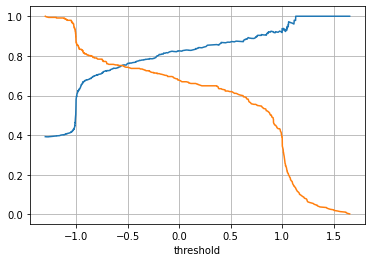

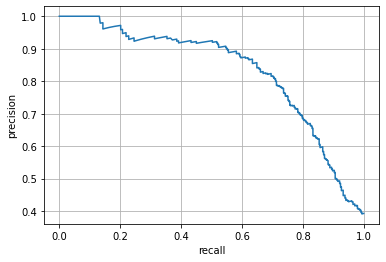

In [15]:
# use SVM cause extra trees doesn't have decision function, 
# and cross_val_predict to work with the whole training dataset
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

pipeline_clf_svm = SVC()

titanic_pipeline_svm = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('clf', pipeline_clf_svm)
    ]
)

y_predicted_scores_svm = cross_val_predict(titanic_pipeline_svm, X, y, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y, y_predicted_scores_svm)

fig, ax = plt.subplots()
ax.plot(thresholds, precisions[:-1]) # additional 1 and 0 for pr and re in precision_recall_curve() are always added
ax.plot(thresholds, recalls[:-1])
ax.set(xlabel='threshold')
ax.grid()
plt.show()

fig, ax = plt.subplots()
ax.plot(recalls, precisions)
ax.set(xlabel='recall', ylabel='precision')
ax.grid()
plt.show()

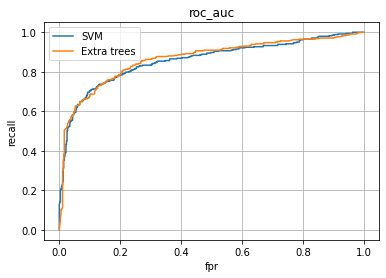

2021-01-04 22:43:53,717 : INFO : Roc_auc_score SVM: 0.8577477391109832
2021-01-04 22:43:53,723 : INFO : Roc_auc_score Extra trees: 0.8656888121944204


In [16]:
# roc_auc for extra trees
from sklearn.metrics import roc_curve, roc_auc_score

fpr_svm, tpr_svm, thresholds_svm = roc_curve(y, y_predicted_scores_svm)
y_predicted_scores = cross_val_predict(titanic_pipeline_baseline, X, y, method='predict_proba')[:, 1]
fpr, tpr, thresholds = roc_curve(y, y_predicted_scores)

fig, ax = plt.subplots()
ax.plot(fpr_svm, tpr_svm, label='SVM')
ax.plot(fpr, tpr, label='Extra trees')
ax.set(title='roc_auc', xlabel='fpr', ylabel='recall')
ax.grid()
ax.legend()
plt.show()

log.info('Roc_auc_score SVM: %s', roc_auc_score(y, y_predicted_scores_svm))
log.info('Roc_auc_score Extra trees: %s', roc_auc_score(y, y_predicted_scores))

In [17]:
# Move precision/recall to try to raise accuracy

low_threshold = 0.25
high_threshold = 0.9

low_threshold_pipeline_predictions = (titanic_pipeline_baseline.predict_proba(X_test)[:, 1] > low_threshold).astype(int)
high_threshold_pipeline_predictions = (titanic_pipeline_baseline.predict_proba(X_test)[:, 1] > high_threshold).astype(int)

csv_predictions(low_threshold_pipeline_predictions, '../predictions/titanic-experiments-low-threshold.csv')
csv_predictions(high_threshold_pipeline_predictions, '../predictions/titanic-experiments-high-threshold.csv')

Saved file: ../predictions/titanic-experiments-low-threshold.csv
Saved file: ../predictions/titanic-experiments-high-threshold.csv


#### Test score pipeline threshold

|  Model | Params | Test score |
|---|---|---|
| Extra trees (median age) low_threshold (0.25) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.73205 |
| Extra trees (median age) high_threshold (0.5) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.77511 |
| Extra trees (median age) high_threshold (0.7) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.77511 |
| Extra trees (median age) high_threshold (0.75) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.77990 |
| Extra trees (median age) high_threshold (0.8) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.78468 |
| Extra trees (median age) high_threshold (0.85) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.77723 |
| Extra trees (median age) high_threshold (0.9) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.77272 |

### Polynomial features

In [18]:
from sklearn.preprocessing import PolynomialFeatures

titanic_pipeline_polynomial = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('poly', PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)),
        ('clf', pipeline_clf)
    ]
)

titanic_pipeline_polynomial.fit(X, y)

predictions_pipeline = titanic_pipeline_polynomial.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-experiments-poly-pipeline.csv')

Saved file: ../predictions/titanic-experiments-poly-pipeline.csv


#### Test score pipeline poly

|  Model | Params | Test score |
|---|---|---|
| Extra trees (median age). Poly 2 degree | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.77751 |
| Extra trees (median age). Poly 3 degree | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.78468 |
| Extra trees (median age). Poly 3 degree, only interaction | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.74641 |

### Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5)

titanic_pipeline_dt = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('clf', dt)
    ]
)
titanic_pipeline_dt.fit(X, y)

predictions_pipeline = titanic_pipeline_dt.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-experiments-pipeline-dt.csv')

Saved file: ../predictions/titanic-experiments-pipeline-dt.csv


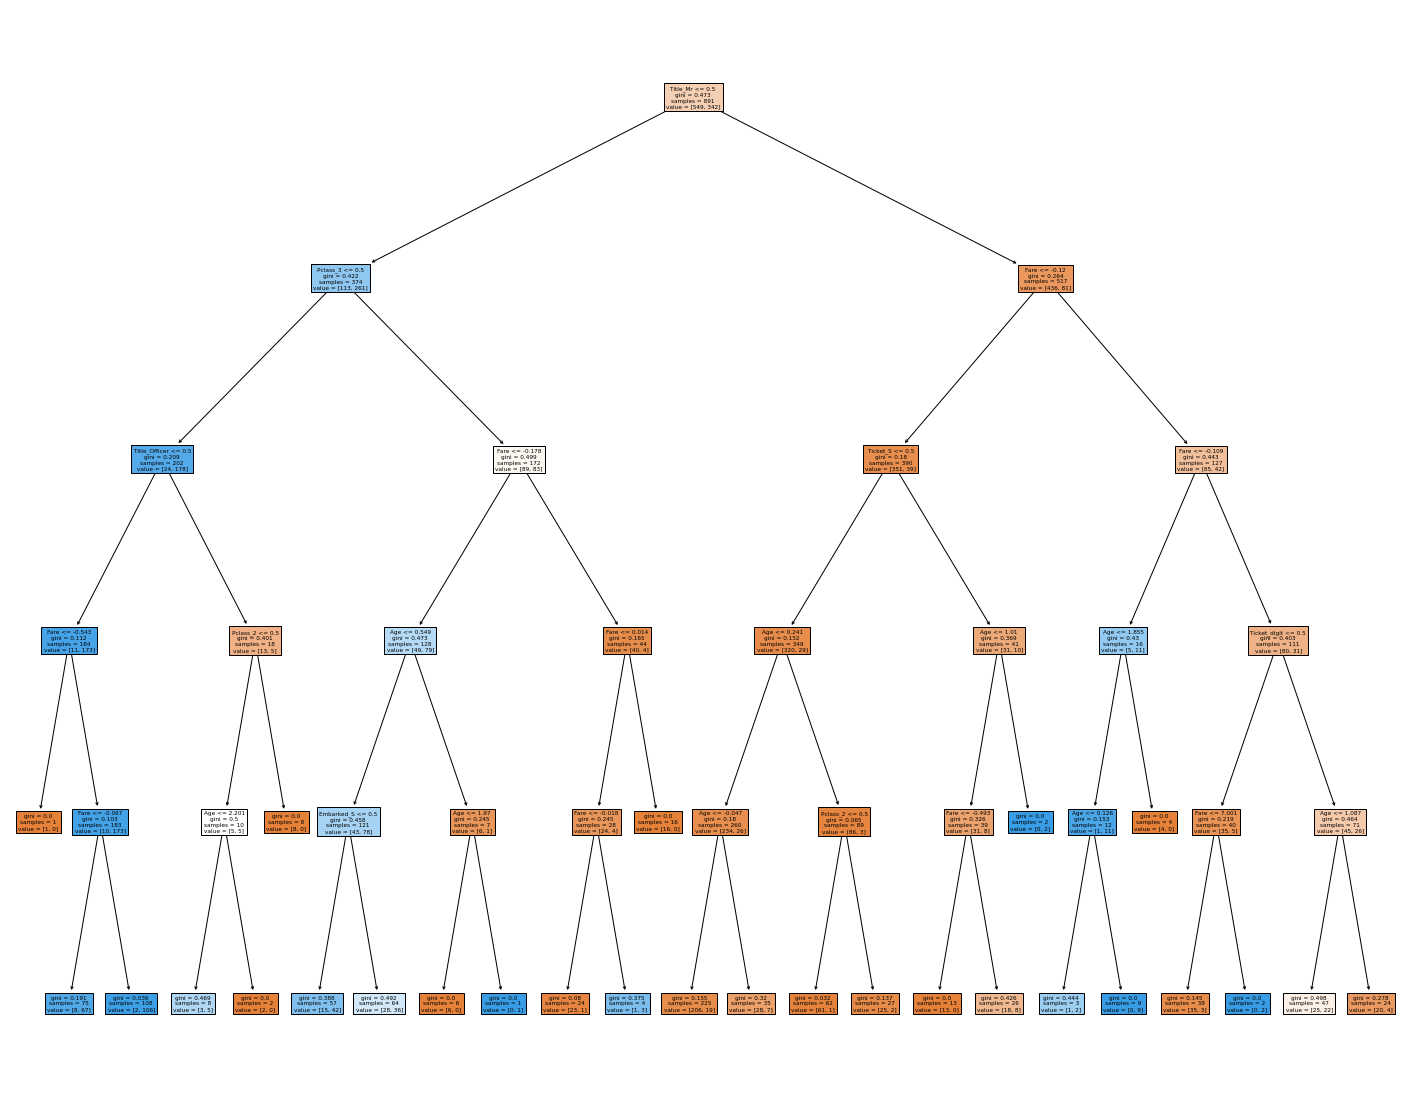

In [20]:
from sklearn import tree
# fig = plt.figure(figsize=(100,80))
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt,
                   feature_names=get_feature_names(titanic_pipeline_dt),
                   filled=True)

In [21]:
text_representation = tree.export_text(dt, feature_names=get_feature_names(titanic_pipeline_dt))
log.info(text_representation)

2021-01-04 22:43:58,833 : INFO : |--- Title_Mr <= 0.50
|   |--- Pclass_3 <= 0.50
|   |   |--- Title_Officer <= 0.50
|   |   |   |--- Fare <= -0.54
|   |   |   |   |--- class: 0
|   |   |   |--- Fare >  -0.54
|   |   |   |   |--- Fare <= -0.07
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Fare >  -0.07
|   |   |   |   |   |--- class: 1
|   |   |--- Title_Officer >  0.50
|   |   |   |--- Pclass_2 <= 0.50
|   |   |   |   |--- Age <= 2.20
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Age >  2.20
|   |   |   |   |   |--- class: 0
|   |   |   |--- Pclass_2 >  0.50
|   |   |   |   |--- class: 0
|   |--- Pclass_3 >  0.50
|   |   |--- Fare <= -0.18
|   |   |   |--- Age <= 0.55
|   |   |   |   |--- Embarked_S <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Embarked_S >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- Age >  0.55
|   |   |   |   |--- Age <= 1.97
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Age >  1.97
|   |   |   |   |   |--- cla

#### Decision tree test score
|  Model | Params | Test score |
|---|---|---|
| Decision tree (median age) | default |  0.71770 |
| Decision tree (median age) | max_depth=5 |  0.75598 |

### Voting classifiers

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier


extra_clf = ExtraTreesClassifier(random_state=args.seed, n_jobs=-1, 
                                    **{'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10})
svm_clf = SVC(probability=True)
log_clf = LogisticRegression()
mlp_clf = MLPClassifier(hidden_layer_sizes=(16, 4))
knn_clf = KNeighborsClassifier()
gnb_clf = GaussianNB()
gb_clf = GradientBoostingClassifier()
vchl_clf = VotingClassifier(estimators=[('extra_clf', extra_clf), 
                                     ('svm_clf', svm_clf), 
                                     ('log_clf', log_clf), 
                                     ('mlp_clf', mlp_clf),
                                     ('knn_clf', knn_clf),
                                     ('gnb_clf', gnb_clf),
                                     ('gb_clf', gb_clf),
                                    ], 
                         voting='hard', n_jobs=args.n_jobs)
vcsl_clf = VotingClassifier(estimators=[('extra_clf', extra_clf), 
                                     ('svm_clf', svm_clf), 
                                     ('log_clf', log_clf), 
                                     ('mlp_clf', mlp_clf),
                                     ('knn_clf', knn_clf),
                                     ('gnb_clf', gnb_clf),
                                     ('gb_clf', gb_clf),
                                    ], 
                         voting='soft', n_jobs=args.n_jobs)
vchs_clf = VotingClassifier(estimators=[('extra_clf', extra_clf), 
                                     ('svm_clf', svm_clf), 
                                     ('log_clf', log_clf),
                                    ], 
                         voting='hard', n_jobs=args.n_jobs)
vcss_clf = VotingClassifier(estimators=[('extra_clf', extra_clf), 
                                     ('svm_clf', svm_clf), 
                                     ('log_clf', log_clf),
                                    ], 
                         voting='soft', n_jobs=args.n_jobs)

for clf in (extra_clf, svm_clf, log_clf, mlp_clf, knn_clf, gnb_clf, gb_clf, vchl_clf, vcsl_clf, vchs_clf, vcss_clf):
    pipeline = Pipeline(
        steps=[
            ('feature-engineering', feature_engineering_col_transformer),
            ('clf', clf)
        ]
    )
    try:
        cv_results = cross_validate(pipeline, X, y, scoring=('accuracy', 'roc_auc'), n_jobs=args.n_jobs)
        log.info("Type: %s. \n 5-fold CV mean scores. Accuracy %s; roc_auc: %s ", 
                 repr(type(pipeline.named_steps['clf'])),
                 repr(np.mean(cv_results['test_accuracy']).round(4)), 
                 repr(np.mean(cv_results['test_roc_auc']).round(4)))
    # can't roc_auc for hard voting
    except AttributeError as _:
        cv_results = cross_validate(pipeline, X, y, scoring=('accuracy'), n_jobs=args.n_jobs)
        log.info("Type: %s. \n 5-fold CV mean scores. Accuracy %s", 
                 repr(type(pipeline.named_steps['clf'])),
                 repr(np.mean(cv_results['test_score']).round(4)))

for clf in ((vchl_clf, "vchl_clf"), (vcsl_clf, "vcsl_clf"), (vchs_clf, "vchs_clf"), (vcss_clf, "vcss_clf")):
    pipeline = Pipeline(
        steps=[
            ('feature-engineering', feature_engineering_col_transformer),
            ('clf', clf[0])
        ]
    )
    pipeline.fit(X, y)
    
    predictions = pipeline.predict(X_test).astype(int)
    csv_predictions(predictions, '../predictions/titanic-experiments-pipeline-voting-{}.csv'.format(clf[1]))

2021-01-04 22:43:59,908 : INFO : Type: <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>. 
 5-fold CV mean scores. Accuracy 0.8137; roc_auc: 0.8696 
2021-01-04 22:44:00,457 : INFO : Type: <class 'sklearn.svm._classes.SVC'>. 
 5-fold CV mean scores. Accuracy 0.8204; roc_auc: 0.8616 
2021-01-04 22:44:00,857 : INFO : Type: <class 'sklearn.linear_model._logistic.LogisticRegression'>. 
 5-fold CV mean scores. Accuracy 0.8193; roc_auc: 0.8652 
2021-01-04 22:44:03,848 : INFO : Type: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>. 
 5-fold CV mean scores. Accuracy 0.8227; roc_auc: 0.8594 
2021-01-04 22:44:04,245 : INFO : Type: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>. 
 5-fold CV mean scores. Accuracy 0.8182; roc_auc: 0.8616 
2021-01-04 22:44:04,550 : INFO : Type: <class 'sklearn.naive_bayes.GaussianNB'>. 
 5-fold CV mean scores. Accuracy 0.7373; roc_auc: 0.8196 
2021-01-04 22:44:05,303 : INFO : Type: <class 'sklearn.ensemble._gb.GradientBoo

Saved file: ../predictions/titanic-experiments-pipeline-voting-vchl_clf.csv
Saved file: ../predictions/titanic-experiments-pipeline-voting-vcsl_clf.csv
Saved file: ../predictions/titanic-experiments-pipeline-voting-vchs_clf.csv
Saved file: ../predictions/titanic-experiments-pipeline-voting-vcss_clf.csv


#### Voting classifier test score
|  Model | Params | Test score |
|---|---|---|
| Voting large | hard |  0.77751 |
| Voting large | soft |  0.76794 |
| Voting small | hard |  0.78229 |
| Voting small | soft |  0.77751 |

### Bagging and Pasting

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

dt = DecisionTreeClassifier(max_depth=5)
bag = BaggingClassifier(dt, n_estimators=200, max_samples=100, n_jobs=args.n_jobs, oob_score=True)
past = BaggingClassifier(dt, n_estimators=200, max_samples=100, bootstrap=False, n_jobs=args.n_jobs)
bag_rp = BaggingClassifier(dt, n_estimators=200, max_samples=100, n_jobs=args.n_jobs, oob_score=True, 
                           max_features=0.5, bootstrap_features=True)
bag_rs = BaggingClassifier(dt, n_estimators=200, max_samples=100, n_jobs=args.n_jobs, oob_score=True, 
                           max_features=0.5, bootstrap_features=False)
extra = ExtraTreesClassifier(random_state=args.seed, n_jobs=-1, 
                             **{'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10})
bag_extra = BaggingClassifier(extra, n_estimators=200, max_samples=100, n_jobs=args.n_jobs, oob_score=True)
past_extra = BaggingClassifier(extra, n_estimators=200, max_samples=100, bootstrap=False, n_jobs=args.n_jobs)

for clf in (dt, bag, past, bag_rp, bag_rs, extra, bag_extra, past_extra):
    pipeline = Pipeline(
        steps=[
            ('feature-engineering', feature_engineering_col_transformer),
            ('clf', clf)
        ]
    )
    cv_results = cross_validate(pipeline, X, y, scoring=('accuracy', 'roc_auc'), n_jobs=args.n_jobs)
    log.info("Type: %s. \n 5-fold CV mean scores. Accuracy %s; roc_auc: %s ", 
             repr(type(pipeline.named_steps['clf'])),
             repr(np.mean(cv_results['test_accuracy']).round(4)), 
             repr(np.mean(cv_results['test_roc_auc']).round(4)))
    if pipeline.named_steps['clf'] in (bag, bag_extra, bag_rp, bag_rs):
        pipeline.fit(X, y)
        log.info("OOB score %s", pipeline.named_steps["clf"].oob_score_.round(4))
        
    
for clf in ((dt, "dt"), (bag, "bag"), (past, "past"), (bag_rp, "bag_rp"), (bag_rs, "bag_rs"),  (extra, "extra"), (bag_extra, "bag_extra"), (past_extra, "past_extra")):
    pipeline = Pipeline(
        steps=[
            ('feature-engineering', feature_engineering_col_transformer),
            ('clf', clf[0])
        ]
    )
    pipeline.fit(X, y)
    
    predictions = pipeline.predict(X_test).astype(int)
    csv_predictions(predictions, '../predictions/titanic-experiments-pipeline-bag-{}.csv'.format(clf[1]))

2021-01-04 22:44:31,892 : INFO : Type: <class 'sklearn.tree._classes.DecisionTreeClassifier'>. 
 5-fold CV mean scores. Accuracy 0.8036; roc_auc: 0.8578 
2021-01-04 22:44:35,266 : INFO : Type: <class 'sklearn.ensemble._bagging.BaggingClassifier'>. 
 5-fold CV mean scores. Accuracy 0.8126; roc_auc: 0.869 
2021-01-04 22:44:35,859 : INFO : OOB score 0.8238
2021-01-04 22:44:38,630 : INFO : Type: <class 'sklearn.ensemble._bagging.BaggingClassifier'>. 
 5-fold CV mean scores. Accuracy 0.8171; roc_auc: 0.8735 
2021-01-04 22:44:41,622 : INFO : Type: <class 'sklearn.ensemble._bagging.BaggingClassifier'>. 
 5-fold CV mean scores. Accuracy 0.817; roc_auc: 0.8684 
2021-01-04 22:44:42,223 : INFO : OOB score 0.8204
2021-01-04 22:44:45,939 : INFO : Type: <class 'sklearn.ensemble._bagging.BaggingClassifier'>. 
 5-fold CV mean scores. Accuracy 0.8193; roc_auc: 0.871 
2021-01-04 22:44:46,913 : INFO : OOB score 0.8227
2021-01-04 22:44:47,856 : INFO : Type: <class 'sklearn.ensemble._forest.ExtraTreesClass

Saved file: ../predictions/titanic-experiments-pipeline-bag-dt.csv
Saved file: ../predictions/titanic-experiments-pipeline-bag-bag.csv
Saved file: ../predictions/titanic-experiments-pipeline-bag-past.csv
Saved file: ../predictions/titanic-experiments-pipeline-bag-bag_rp.csv
Saved file: ../predictions/titanic-experiments-pipeline-bag-bag_rs.csv
Saved file: ../predictions/titanic-experiments-pipeline-bag-extra.csv
Saved file: ../predictions/titanic-experiments-pipeline-bag-bag_extra.csv
Saved file: ../predictions/titanic-experiments-pipeline-bag-past_extra.csv


#### Baggging classifier test score
|  Model | Params | Test score |
|---|---|---|
| Dt large | max_depth=5 |  0.75598 |
| Bag dt| n_estimators=200, max_samples=100 |  0.78708 |
| Past dt | n_estimators=200, max_samples=100 |  0.77990 |
| Bag dt random patches| n_estimators=200, max_samples=100, max_features=0.5, bootstrap_features=True |  0.77990 |
| Bag dt random subspaces| n_estimators=200, max_samples=100, max_features=0.5, bootstrap_features=False |  0.77990 |
| Extra | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.78468 |
| Bag extra| n_estimators=200, max_samples=100 |  0.78229 |
| Past extra | n_estimators=200, max_samples=100 |  0.78229 |

### AdaBoost

In [24]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(random_state=args.seed,n_estimators=500)

pipeline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('clf',ada_clf)
    ]
)
pipeline.fit(X, y)

predictions_pipeline = pipeline.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-experiments-ada.csv')

Saved file: ../predictions/titanic-experiments-ada.csv


#### AdaBoost test score
|  Model | Params | Test score |
|---|---|---|
| AdaBoostClassifier | default | 0.75598 |
| AdaBoostClassifier | n_estimators=200 | 0.76076 |
| AdaBoostClassifier | n_estimators=500 | 0.76315 |

### Gradient boosting

Saved file: ../predictions/titanic-experiments-gb-default.csv


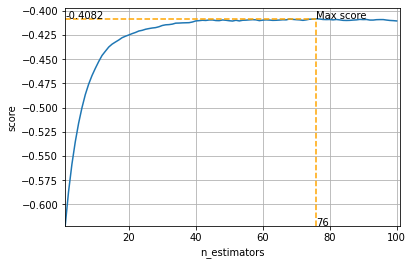

2021-01-04 22:48:21,105 : INFO : Best n_estimators: 76


Saved file: ../predictions/titanic-experiments-gb.csv


In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

gb_default_clf = GradientBoostingClassifier(random_state=args.seed)

pipeline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('clf',gb_default_clf)
    ]
)
pipeline.fit(X, y)

predictions_pipeline = pipeline.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-experiments-gb-default.csv')


def get_gb_best_n_estimnators(n_estimators_max=500):
    def _print_score_n_estimators(scores):
        xmax = np.argmax(scores) + 1
        ymax = scores[xmax - 1]
        fig, ax = plt.subplots()
        ax.plot(range(1, len(scores) + 1), scores)
        ax.plot([xmax, xmax], [scores[0], ymax], linestyle="dashed", color="orange")
        ax.plot([1, xmax], [ymax, ymax], linestyle="dashed", color="orange")
        ax.set(xlabel='n_estimators', ylabel='score')
        ax.set_xlim(1, len(scores) + 1)
        ax.set_ylim(ymin=np.min(scores))
        ax.annotate('Max score', xy=(xmax, ymax), xytext=(xmax, ymax))
        ax.annotate(repr(xmax), xy=(xmax, np.min(scores)), xytext=(xmax, np.min(scores)))
        ax.annotate(repr(ymax), xy=(1, ymax), xytext=(1, ymax))
        ax.grid()
        plt.show()
    assert n_estimators_max >= 1
    log_losses = []
    for n in range(1, n_estimators_max + 1):
        gb_clf = GradientBoostingClassifier(random_state=args.seed, n_estimators=n)

        pipeline = Pipeline(
            steps=[
                ('feature-engineering', feature_engineering_col_transformer),
                ('clf',gb_clf)
            ]
        )
        cv_results = cross_validate(pipeline, X, y, scoring=('neg_log_loss'), n_jobs=args.n_jobs)
        log_losses.append(np.mean(cv_results['test_score']).round(4))
    
    _print_score_n_estimators(log_losses)
    return np.argmax(log_losses) + 1

best_n_estimators = get_gb_best_n_estimnators(100)

log.info('Best n_estimators: %s', repr(best_n_estimators))
gb_clf = GradientBoostingClassifier(random_state=args.seed, n_estimators=best_n_estimators)

pipeline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('clf',gb_clf)
    ]
)
pipeline.fit(X, y)

predictions_pipeline = pipeline.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-experiments-gb.csv')

#### GradientBoosting test score
|  Model | Params | Test score |
|---|---|---|
| GradientBoostingClassifier | default | 0.77751 |
| GradientBoostingClassifier | best n_estimators=76 | 0.77272 |

### Stacking

In [26]:
from sklearn.ensemble import StackingClassifier

extra_clf = ExtraTreesClassifier(random_state=args.seed, n_jobs=-1, 
                                    **{'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10})
svm_clf = SVC(probability=True, random_state=args.seed)
mlp_clf = MLPClassifier(hidden_layer_sizes=(16, 4), random_state=args.seed)
knn_clf = KNeighborsClassifier()
gnb_clf = GaussianNB()
gb_clf = GradientBoostingClassifier(random_state=args.seed)

log_clf = LogisticRegression(random_state=args.seed)

sts_clf = StackingClassifier(estimators=[('extra_clf', extra_clf), 
                                     ('svm_clf', svm_clf), 
                                     ('mlp_clf', mlp_clf),
                                    ], 
                         final_estimator=log_clf, n_jobs=args.n_jobs)

stl_clf = StackingClassifier(estimators=[('extra_clf', extra_clf), 
                                     ('svm_clf', svm_clf), 
                                     ('mlp_clf', mlp_clf),
                                     ('knn_clf', knn_clf),
                                     ('gnb_clf', gnb_clf),
                                     ('gb_clf', gb_clf),
                                    ], 
                         final_estimator=log_clf, n_jobs=args.n_jobs)


for clf in ((sts_clf, "sts_clf"), (stl_clf, "stl_clf")):
    pipeline = Pipeline(
        steps=[
            ('feature-engineering', feature_engineering_col_transformer),
            ('clf', clf[0])
        ]
    )
    cv_results = cross_validate(pipeline, X, y, scoring=('accuracy', 'roc_auc'), n_jobs=args.n_jobs)
    log.info("Type: %s. \n 5-fold CV mean scores. Accuracy %s; roc_auc: %s ", 
             repr(type(pipeline.named_steps['clf'])),
             repr(np.mean(cv_results['test_accuracy']).round(4)), 
             repr(np.mean(cv_results['test_roc_auc']).round(4)))
    
    pipeline.fit(X, y)
    
    predictions = pipeline.predict(X_test).astype(int)
    csv_predictions(predictions, '../predictions/titanic-experiments-pipeline-stacking-{}.csv'.format(clf[1]))

2021-01-04 22:48:36,131 : INFO : Type: <class 'sklearn.ensemble._stacking.StackingClassifier'>. 
 5-fold CV mean scores. Accuracy 0.8272; roc_auc: 0.8731 


Saved file: ../predictions/titanic-experiments-pipeline-stacking-sts_clf.csv


2021-01-04 22:49:00,747 : INFO : Type: <class 'sklearn.ensemble._stacking.StackingClassifier'>. 
 5-fold CV mean scores. Accuracy 0.8249; roc_auc: 0.8779 


Saved file: ../predictions/titanic-experiments-pipeline-stacking-stl_clf.csv


#### Stacking test score
|  Model | Params | Test score |
|---|---|---|
| Stacking small | default | 0.77272 |
| Stacking large | default | 0.77272 |

### Isolation forest

In [27]:
from sklearn.ensemble import IsolationForest

if_clf = IsolationForest(random_state=args.seed, n_jobs=args.n_jobs, n_estimators=1000)

pipeline = Pipeline(
        steps=[
            ('feature-engineering', feature_engineering_col_transformer),
            ('clf', if_clf)
        ]
    )

pipeline.fit(X)
outliers = pipeline.predict(X)
X_clean = X[outliers == 1]
y_clean = y[outliers == 1]
titanic_pipeline_baseline.fit(X_clean, y_clean)
titanic_predictions = titanic_pipeline_baseline.predict(X_test).astype(int)
csv_predictions(titanic_predictions, '../predictions/titanic-experiments-no-outliers.csv')

Saved file: ../predictions/titanic-experiments-no-outliers.csv


#### Isolation forest test score
|  Model | Params | Test score |
|---|---|---|
| Isolation forest | n_estimators=1000 | 0.77272 |

### Hist gradient boosting

In [28]:
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_clf = HistGradientBoostingClassifier(random_state=args.seed)

pipeline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('clf', hgb_clf)
    ]
)
pipeline.fit(X, y)

predictions_pipeline = pipeline.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-experiments-hgb.csv')

Saved file: ../predictions/titanic-experiments-hgb.csv


#### Isolation forest test score
|  Model | Params | Test score |
|---|---|---|
| Hist gradient boosting | default | 0.73444 |

### Dimensionality reduction

In [29]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

clf = ExtraTreesClassifier(random_state=args.seed, n_jobs=-1, 
                                    **{'max_depth': 20, 'min_samples_leaf': 7, 'n_estimators': 10})
pca = PCA(n_components=0.9)

pipeline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('pca', pca),
        ('clf', clf)
    ]
)
pipeline.fit(X, y)
predictions = pipeline.predict(X_test).astype(int)
csv_predictions(predictions, '../predictions/titanic-experiments-pca.csv')

lle = LocallyLinearEmbedding(n_components=5, n_neighbors=15)
pipeline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('lle', lle),
        ('clf', clf)
    ]
)
pipeline.fit(X, y)
predictions = pipeline.predict(X_test).astype(int)
csv_predictions(predictions, '../predictions/titanic-experiments-lle.csv')


kernel_pca = KernelPCA(random_state=args.seed)
clf = ExtraTreesClassifier(random_state=args.seed, n_jobs=-1)
pipeline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('dim', kernel_pca),
        ('clf', clf)
    ]
)

params = {
    'dim__n_components': [3, 5, 10, 15],
    'dim__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'cosine', 'precomputed'],
    'dim__gamma': [0.01, 0.1, 1],
    'dim__degree': [2, 3],
    'clf__max_depth': [5, 10, 20, 30],
    'clf__min_samples_leaf': [3, 5, 7, 10],
    'clf__n_estimators': [5, 10, 20],
}
skf = StratifiedKFold(n_splits=args.splits, shuffle=True, random_state=args.seed)

rscv = RandomizedSearchCV(pipeline, param_distributions=params, cv=skf, verbose=1, n_jobs=args.n_jobs, random_state=args.seed)
rscv.fit(X, y)
log.info('CV score: %s. Best_params: %s', repr(rscv.best_score_), repr(rscv.best_params_))
predictions = rscv.best_estimator_.predict(X_test).astype(int)
csv_predictions(predictions, '../predictions/titanic-experiments-dim-rscv.csv')

Saved file: ../predictions/titanic-experiments-pca.csv
Saved file: ../predictions/titanic-experiments-lle.csv
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.1s finished
2021-01-04 22:49:22,012 : INFO : CV score: 0.8002448057246877. Best_params: {'dim__n_components': 15, 'dim__kernel': 'poly', 'dim__gamma': 0.01, 'dim__degree': 3, 'clf__n_estimators': 5, 'clf__min_samples_leaf': 5, 'clf__max_depth': 30}


Saved file: ../predictions/titanic-experiments-dim-rscv.csv


#### Dimensionality reduction test score
|  Model | Params | Test score |
|---|---|---|
| PCA | n_components=0.95 | 0.78468 |
| PCA | n_components=0.90 | 0.77990 |
| LLE | n_components=11, n_neighbors=50 | 0.76555 |
| LLE | n_components=5, n_neighbors=15 | 0.75598 |
| Random search, KernelPCA | best | 0.75358 |

### K-Means

2021-01-05 17:30:47,080 : INFO : Inertia: [inf, inf, 3514.025, 3013.399, 2635.246, 2431.113, 2265.109, 2102.731, 1970.0, 1874.172, 1794.595, 1702.82, 1624.606, 1584.424, 1549.404, 1494.776]
2021-01-05 17:30:47,086 : INFO : Scores: [0, 0, 0.275, 0.207, 0.216, 0.214, 0.226, 0.23, 0.23, 0.223, 0.227, 0.224, 0.228, 0.234, 0.237, 0.239]


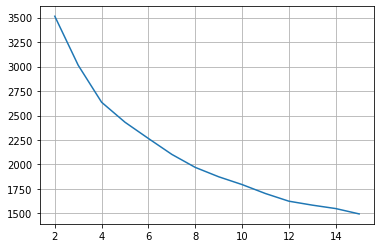

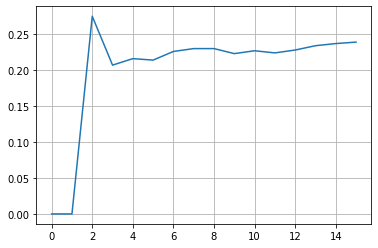

2021-01-05 17:30:47,963 : INFO : Intersection ratio: 0.327


Saved file: ../predictions/titanic-experiments-kmeans.csv


In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

max_n_clusters = 16
def choose_n_clusters():
    inertia = [float('inf'), float('inf')]
    scores = [0, 0]
    for n_clusters in range(2, max_n_clusters):
        kmeans = KMeans(n_clusters=n_clusters, random_state=args.seed)
        pipeline = Pipeline(
            steps=[
                ('feature-engineering', feature_engineering_col_transformer),
                ('clf', kmeans)
            ]
        )
        pipeline.fit(X, y)
        inertia.append(round(pipeline.named_steps['clf'].inertia_, 3))
        scores.append(round(silhouette_score(pipeline.named_steps['feature-engineering'].transform(X), pipeline.named_steps['clf'].labels_), 3))

    log.info('Inertia: %s', inertia)
    log.info('Scores: %s', scores)
    
    fig, ax = plt.subplots()
    ax.plot(range(max_n_clusters), inertia, label='SVM')
    ax.grid()
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot(range(max_n_clusters), scores, label='SVM')
    ax.grid()
    plt.show()
    
    return np.argmax(scores)
    
n_clusters = choose_n_clusters()
kmeans = KMeans(n_clusters=n_clusters, random_state=args.seed)
pipeline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('clf', kmeans)
    ]
)
pipeline.fit(X, y)
y_pred = pipeline.predict(X)
y_intersect = y_pred == y
log.info('Intersection ratio: %.3f', np.sum(y_intersect==True)/len(y))

# preprocess with kmeans
kmeans = KMeans(n_clusters=4, random_state=args.seed)
clf = ExtraTreesClassifier(random_state=args.seed, n_jobs=-1, 
                                    **{'max_depth': 20, 'min_samples_leaf': 7, 'n_estimators': 10})
pipeline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('kmeans', kmeans),
        ('clf', clf)
    ]
)
pipeline.fit(X, y)
predictions_pipeline = pipeline.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-experiments-kmeans.csv')

#### K-Means test score
|  Model | Params | Test score |
|---|---|---|
| K-Means | n_clusters=7 | 0.71291 |

In [31]:
# K-Means for semi-supervised learning
# Baseline models with min and max n_labeled
from sklearn.ensemble import ExtraTreesClassifier

n_labeled = 180
clf = ExtraTreesClassifier(random_state=args.seed, n_jobs=-1, 
                                    **{'max_depth': 20, 'min_samples_leaf': 7, 'n_estimators': 10})

pipeline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('clf', clf)
    ]
)
pipeline.fit(X[:n_labeled], y[:n_labeled])
predictions_pipeline = pipeline.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-experiments-baseline-180.csv')

Saved file: ../predictions/titanic-experiments-baseline-180.csv


In [34]:
# Preporcessing of min n_labeled samples
from sklearn.model_selection import GridSearchCV, StratifiedKFold

clf = ExtraTreesClassifier(random_state=args.seed, n_jobs=-1, 
                                    **{'max_depth': 20, 'min_samples_leaf': 7, 'n_estimators': 10})
n_clusters = range(2, 101)
kmeans = KMeans(n_clusters=n_clusters, random_state=args.seed)


pipeline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('kmeans', kmeans),
        ('clf', clf)
    ]
)
pipeline.fit(X[:n_labeled], y[:n_labeled])
predictions_pipeline = pipeline.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-experiments-semi-8.csv')


params = {
    'kmeans__n_clusters': range(2, 101),
}
skf = StratifiedKFold(n_splits=args.splits, shuffle=True, random_state=args.seed)

gscv = GridSearchCV(pipeline, params=params, cv=skf, verbose=1, n_jobs=args.n_jobs, random_state=args.seed)
gscv.fit(X, y)
log.info('CV score: %s. Best_params: %s', repr(gscv.best_score_), repr(gscv.best_params_))
predictions = gscv.best_estimator_.predict(X_test).astype(int)
csv_predictions(predictions, '../predictions/titanic-experiments-semi-grid.csv')

Saved file: ../predictions/titanic-experiments-semi-8.csv


#### K-Means semi-supervised test score
|  Model | Params | Test score |
|---|---|---|
| ExtraTreesClassifier | n_labeled=180 | 0.76076 |
| ExtraTreesClassifier | n_labeled=891 | 0.77990 |
| ExtraTreesClassifier | n_labeled=180, n_clusters=8 | 0.62200 |